<a href="https://colab.research.google.com/github/khaophuthaipch/EAI6000/blob/master/First_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team: Sagar Daswani and Pimchanok Khaoputhai**
# **EAI6000 - Foundations of AI**

# Final Project
## Initial report

#**Real or Not? Binary Classification of Disaster Tweets**
Kaggle Competition

Nowadays, social media has become a part of our daily life. People are sharing their experience and communicate to the public through platform like Facebook and Twitter. Sometimes, these channels are used for sharing emergency matters and news. However, the problem relies on whether the message posted is real. This project is focusing on detecting if a post on Twitter about disaster is a real event.

The dataset contains 10,000 tweets with hand classified.

In [0]:
import pandas as pd
from nltk.tokenize import word_tokenize
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
  

## Get the Dataset from Kaggle API
*   Set up the API
*   Download data using !kaggle competitions
*   Import data






In [0]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khaophuthaipkt","key":"742f0323b5693f569538176eceaa4d80"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
sudalairajkumar/novel-corona-virus-2019-dataset             Novel Corona Virus 2019 Dataset                     359KB  2020-03-15 04:49:56          45424  
kimjihoo/coronavirusdataset                                 Coronavirus-Dataset                                  32KB  2020-03-13 13:48:11          14507  
shivamb/real-or-fake-fake-jobposting-prediction             [Real or Fake] Fake JobPosting Prediction            16MB  2020-02-29 08:23:34           1487  
imdevskp/sars-outbreak-2003-complete-dataset                SARS 2003 Outbreak Complete Dataset                  10KB  2020-02-26 10:25:22           1273  
imdevskp/ebola-outbreak-20142016-complete-dataset           Ebol

In [5]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 36.9MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.8MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 109MB/s]


In [0]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [9]:
#Looking at first few rows of dataset
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
print("Training Dataset Size:",train_df.shape)
print("Test Dataset Size:",test_df.shape)

Training Dataset Size: (7613, 5)
Test Dataset Size: (3263, 4)


In [0]:
#missing values in training dataset
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [0]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [0]:
#exlporing location column
train_df['location'].value_counts()

USA                             104
New York                         71
United States                    50
London                           45
Canada                           29
                               ... 
In your head                      1
Blogland                          1
London/Surrey                     1
Rheinbach / Germany               1
Trinity, Bailiwick of Jersey      1
Name: location, Length: 3341, dtype: int64

##**Data Cleaning**


*   Making all uppercase to lowercase
*   Removing noise from tweets

  *   URLs
  *   HTML tags
  *   emogis
  *   Punctuation
  *   New-Line
  *   Removing Digits
*   Tokenization: Converting normal text string into a list of tokens/words
*   Stopwords removal(optional)


In [0]:
#function to remove noise from text
def clean_text(text):
    text = text.lower() #convert to lowercase to maintain standard flow between text
    text = re.sub('\[.*?\]', '', text) #removing text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #removing url
    text = re.sub('<.*?>+', '', text) #removing html tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #removing puntuations
    text = re.sub('\n', '', text)#removing new line from the text field
    text = re.sub('\w*\d\w*', '', text) #removing digits from the string
    return text

train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

In [0]:
#function to remove emoji's
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df['text']=train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text']=test_df['text'].apply(lambda x: remove_emoji(x))

In [0]:
#adding new column with the count of words in a single row
train_df['word_count'] = train_df['text'].str.split().map(len)

#only using the rows with word count more than 0
train_df = train_df[train_df['word_count'] > 0]

#moving forward with 2 column from dataset , i.e., text and target
train_df = train_df[["text","target"]]
test_df = test_df[["text"]]

## **Word Embedding** 
Tensorflow model


In [0]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
training_sentences = [ i for i in train_df.text[:6000]]
test_sentences = [i for i in train_df.text[6000:]]
                  
training_labels = [ i for i in train_df.target[:6000]]
test_labels = [i for i in train_df.target[6000:]]


In [0]:
tokenizer = Tokenizer(num_words=10000,oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [0]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,padding='post')


In [0]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adagrad',metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_14  (None, 16)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 - 1s - loss: 0.6675 - accuracy: 0.5830 - val_loss: 0.6622 - val_accuracy: 0.5385
Epoch 2/20
6000/6000 - 1s - loss: 0.5571 - accuracy: 0.7517 - val_loss: 0.5541 - val_accuracy: 0.7308
Epoch 3/20
6000/6000 - 1s - loss: 0.4215 - accuracy: 0.8363 - val_loss: 0.4897 - val_accuracy: 0.7792
Epoch 4/20
6000/6000 - 1s - loss: 0.3405 - accuracy: 0.8652 - val_loss: 0.4688 - val_accuracy: 0.7909
Epoch 5/20
6000/6000 - 1s - loss: 0.2847 - accuracy: 0.8890 - val_loss: 0.4659 - val_accuracy: 0.7891
Epoch 6/20
6000/6000 - 1s - loss: 0.2413 - accuracy: 0.9088 - val_loss: 0.4781 - val_accuracy: 0.7854
Epoch 7/20
6000/6000 - 1s - loss: 0.2055 - accuracy: 0.9255 - val_loss: 0.4952 - val_accuracy: 0.7860
Epoch 8/20
6000/6000 - 1s - loss: 0.1775 - accuracy: 0.9347 - val_loss: 0.5292 - val_accuracy: 0.7835
Epoch 9/20
6000/6000 - 1s - loss: 0.1526 - accuracy: 0.9463 - val_loss: 0.5523 - val_accuracy: 0.7717
Epoch 10/20
6000/6000 - 1s - loss:

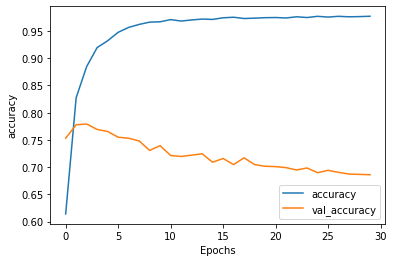

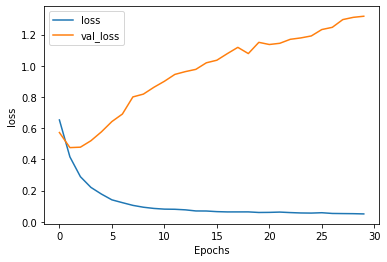

In [0]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(train_df.target[2])

our deeds are the reason of this earthquake may allah forgive us all ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
1


In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [0]:
sentence = ["granny starting to fear spiders in the garden might be real", "earthquake is in my neighborhood"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, padding='post')
print(model.predict(padded))

[[2.0326643e-04]
 [9.9998784e-01]]
